# Dependencies

In [178]:
! pip install yfinance
! pip install plotly
! pip install pandas_ta
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [179]:
# Raw Packages
import numpy as np
import pandas as pd
import pandas_ta as ta
from functools import reduce

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

# Data Source
import yfinance as yf

# Data Visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sn
import shap

## Data Collection

In [180]:
def readCSV(filename):
  df = pd.read_csv(filename, na_values='.')
  df['Date'] = pd.to_datetime(df['DATE'])
  df.set_index('Date', inplace=True)

  return df

In [181]:
def convert_monthly_to_daily(dataframe):

  start_date = dataframe.index.min() - pd.DateOffset(day=1)
  end_date = dataframe.index.max() + pd.DateOffset(day=31)
  
  dates = pd.date_range(start_date, end_date, freq='D')
  dates.name = 'Date'
  dataframe = dataframe.reindex(dates, method='ffill')

  dataframe.reset_index(inplace=True)
  dataframe.drop('DATE', inplace=True, axis=1)
  #dataframe.set_index('Date', inplace=True)

  return dataframe

In [182]:
# Daily Macroeconomic Indicators
emu_df = readCSV('WLEMUINDXD.csv')                                     # Equity Market-related Economic Uncertainty Index                        / 2017-07-17 - 2022-07-17
vix_df = readCSV('VIXCLS.csv')                                         # Volatility Index                                                        / 2017-07-17 - 2022-07-15 
epu_df = readCSV('USEPUINDXD.csv')                                     # Economic Policy Uncertainty Index for US                                / 2017-07-17 - 2022-07-17
ir5_df = readCSV('T5YIFR.csv')                                         # 5-Year Forward Inflation Expectation Rate                               / 2017-07-18 - 2022-07-18
ovx_df = readCSV('OVXCLS.csv')                                         # Crude Oil ETF Volatility Index                                          / 2017-07-17 - 2022-07-15
dsg_df = readCSV('DGS10.csv')                                          # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity   / 2017-07-17 - 2022-07-15

# Monthly Macroeconomic Indicators 
tb3_df = convert_monthly_to_daily(readCSV('TB3MS.csv'))                # 3-Month Treasury Bill Secondary Market Rate                             / 1934-01-01 - 2022-06-30
emv_df = convert_monthly_to_daily(readCSV('EMVOVERALLEMV.csv'))        # Equity Market Volatility Tracker                                        / 1985-01-01 - 2022-06-30
icp_df = convert_monthly_to_daily(readCSV('FPCPITOTLZGUSA.csv'))       # Inflation, consumer prices for USA                                      / 1960-01-01 - 2021-01-31

In [183]:
# *NOTE* (Revisit) Twitter Sentiment Dataset Time Range: 2021-02-05 to 2022-07-09

btc_df = yf.download(tickers='BTC-USD', start="2019-01-01", end="2021-12-31")
#btc_df = yf.download(tickers='BTC-USD', start="2021-02-05", end="2022-07-09")
gld_df = yf.download(tickers='GC=F', start="2019-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [184]:
print(btc_df.shape)

(1096, 6)


In [185]:
# *NOTE* Decide What to do with icp_df because of date range, removing...
#btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df, icp_df]
btc_df = [btc_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df]
#btc_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
#                                            how='inner'), btc_df)
btc_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                             how='left'), btc_df)
btc_df_merged.drop('DATE_x', inplace=True, axis=1)
btc_df_merged.drop('DATE_y', inplace=True, axis=1)

Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.


In [186]:
# Not sure if I can delete
btc_df_merged.reset_index(inplace=True)

In [187]:
print(btc_df_merged.shape)

(1096, 16)


In [188]:
# forward fill macroeconomic NaN values 
btc_df_merged.ffill(inplace=True)

In [189]:
# We will remove the first value from the data frame as it cannot forward fill
print(btc_df_merged[btc_df_merged.isnull().any(axis=1)])
btc_df_merged = btc_df_merged.iloc[1: , :]
print(btc_df_merged[btc_df_merged.isnull().any(axis=1)]) # Should be empty

   index       Date         Open         High          Low       Close  \
0      0 2019-01-01  3746.713379  3850.913818  3707.231201  3843.52002   

    Adj Close      Volume  WLEMUINDXD  VIXCLS  USEPUINDXD  T5YIFR  OVXCLS  \
0  3843.52002  4324200990      200.86     NaN      204.03     NaN     NaN   

   DGS10  TB3MS  EMVOVERALLEMV  
0    NaN   2.37       38.00638  
Empty DataFrame
Columns: [index, Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV]
Index: []


In [190]:
gld_df = [gld_df, emu_df, vix_df, epu_df, ir5_df, ovx_df, dsg_df, tb3_df, emv_df]
gld_df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), gld_df)
gld_df_merged.drop('DATE_x', inplace=True, axis=1)
gld_df_merged.drop('DATE_y', inplace=True, axis=1)

Passing 'suffixes' which cause duplicate columns {'DATE_x'} in the result is deprecated and will raise a MergeError in a future version.


In [191]:
print(gld_df_merged.shape)

(900, 15)


In [192]:
# forward fill macroeconomic NaN values 
gld_df_merged.ffill(inplace=True)

In [193]:
# We will remove the first value from the data frame as it cannot forward fill
print(gld_df_merged[gld_df_merged.isnull().any(axis=1)])
gld_df_merged = gld_df_merged.iloc[1: , :]
print(gld_df_merged[gld_df_merged.isnull().any(axis=1)]) # Should be empty

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, WLEMUINDXD, VIXCLS, USEPUINDXD, T5YIFR, OVXCLS, DGS10, TB3MS, EMVOVERALLEMV]
Index: []


In [194]:
def rsi(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['rsi_u'] = 0.
  data['rsi_d'] = 0.
  data['RSI'] = 0.
  
  for index,row in data.iterrows():
      if index >= periods:
          
          prev_close = data.at[index-periods, close_col]
          if prev_close < row[close_col]:
              data.at[index, 'rsi_u'] = row[close_col] - prev_close
          elif prev_close > row[close_col]:
              data.at[index, 'rsi_d'] = prev_close - row[close_col]
          
  data['RSI'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() + data['rsi_d'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean())
  
  data = data.drop(['rsi_u', 'rsi_d'], axis=1)
  data.set_index('Date', inplace=True)
  return data

In [195]:
btc_df_merged = rsi(btc_df_merged)
gld_df_merged = rsi(gld_df_merged)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [196]:
def ema(data, period=0, column='Close'):
  data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
  
  return data

def macd(data, period_long=26, period_short=12, period_signal=9, column='Close'):
  remove_cols = []
  data.reset_index(inplace=True)
  if not 'ema' + str(period_long) in data.columns:
    data = ema(data, period_long)
    remove_cols.append('ema' + str(period_long))

  if not 'ema' + str(period_short) in data.columns:
    data = ema(data, period_short)
    remove_cols.append('ema' + str(period_short))

  data['MACD'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
  data['MACD_Signal_Line'] = data['MACD'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

  data = data.drop(remove_cols, axis=1)
  data.set_index('Date', inplace=True)
      
  return data

In [197]:
btc_df_merged = macd(btc_df_merged)
gld_df_merged = macd(gld_df_merged)

In [198]:
def ADX(df):
  high = df['High']
  low = df['Low']
  close = df['Close']
  lookback = 14
  adx = pd.DataFrame()
  plus_dm = high.diff()
  minus_dm = low.diff()
  plus_dm[plus_dm < 0] = 0
  minus_dm[minus_dm > 0] = 0
  
  tr1 = pd.DataFrame(high - low)
  tr2 = pd.DataFrame(abs(high - close.shift(1)))
  tr3 = pd.DataFrame(abs(low - close.shift(1)))
  frames = [tr1, tr2, tr3]
  tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
  atr = tr.rolling(lookback).mean()
  
  plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
  minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
  dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
  adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
  adx_smooth = adx.ewm(alpha = 1/lookback).mean()
  return adx_smooth

In [199]:
btc_df_merged['ADX'] = ADX(btc_df_merged)
gld_df_merged['ADX'] = ADX(gld_df_merged)

In [200]:
def stochastic_fast_slow(df):
  low_min = df['Low'].rolling(window=14).min()
  high_max = df['High'].rolling(window=14).max()

  k_fast = 100 * (df['Close'] - low_min)/(high_max - low_min)
  d_fast = k_fast.rolling(window = 3).mean()

  k_slow = d_fast
  d_slow = k_slow.rolling(window = 3).mean()

  return k_fast, d_fast, k_slow, d_slow

In [201]:
btc_df_merged['STOFASTK'] = stochastic_fast_slow(btc_df_merged)[0]
btc_df_merged['STOFASTD'] = stochastic_fast_slow(btc_df_merged)[1]
btc_df_merged['STOSLOWD'] = stochastic_fast_slow(btc_df_merged)[3]

gld_df_merged['STOFASTK'] = stochastic_fast_slow(gld_df_merged)[0]
gld_df_merged['STOFASTD'] = stochastic_fast_slow(gld_df_merged)[1]
gld_df_merged['STOSLOWD'] = stochastic_fast_slow(gld_df_merged)[3]

In [202]:
btc_df_merged['MA50'] = btc_df_merged['Close'].rolling(window=50).mean()
btc_df_merged['MA200'] = btc_df_merged['Close'].rolling(window=200).mean()

gld_df_merged['MA50'] = gld_df_merged['Close'].rolling(window=50).mean()
gld_df_merged['MA200'] = gld_df_merged['Close'].rolling(window=200).mean()

In [203]:
def ROC(data, periods=14, close_col='Close'):
  data.reset_index(inplace=True)
  data['ROC'] = 0.
  
  for index,row in data.iterrows():
    if index >= periods:
      prev_close = data.at[index-periods, close_col]
      val_perc = (row[close_col] - prev_close)/prev_close

      data.at[index, 'ROC'] = val_perc
  data.set_index('Date', inplace=True)
  return data

In [204]:
btc_df_merged = ROC(btc_df_merged)
gld_df_merged = ROC(gld_df_merged)

In [205]:
def OBV(data):
  trend_periods = 21
  close_col = 'Close'
  vol_col = 'Volume'
  data.reset_index(inplace=True)
  for index, row in data.iterrows():
    if index > 0:
      last_obv = data.at[index - 1, 'OBV']
      if row[close_col] > data.at[index - 1, close_col]:
        current_obv = last_obv + row[vol_col]
      elif row[close_col] < data.at[index - 1, close_col]:
        current_obv = last_obv - row[vol_col]
      else:
        current_obv = last_obv
    else:
      last_obv = 0
      current_obv = row[vol_col]

    data.at[index, 'OBV'] = current_obv

  data.set_index('Date', inplace=True)
  return data

In [206]:
btc_df_merged = OBV(btc_df_merged)

gld_df_merged = OBV(gld_df_merged)

In [207]:
def typical_price(data, high_col = 'High', low_col = 'Low', close_col = 'Close'):
  data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3

  return data

def MFI(data, periods=14, vol_col='Volume'):
  data.reset_index(inplace=True)
  remove_tp_col = False
  if not 'typical_price' in data.columns:
    data = typical_price(data)
    remove_tp_col = True
  
  data['money_flow'] = data['typical_price'] * data[vol_col]
  data['money_ratio'] = 0.
  data['MFI'] = 0.
  data['money_flow_positive'] = 0.
  data['money_flow_negative'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      if row['typical_price'] < data.at[index-1, 'typical_price']:
          data.at[index, 'money_flow_positive'] = row['money_flow']
      else:
          data.at[index, 'money_flow_negative'] = row['money_flow']

    if index >= periods:
      period_slice = data['money_flow'][index-periods:index]
      positive_sum = data['money_flow_positive'][index-periods:index].sum()
      negative_sum = data['money_flow_negative'][index-periods:index].sum()

      if negative_sum == 0.:
        #this is to avoid division by zero below
        negative_sum = 0.00001
      m_r = positive_sum / negative_sum

      mfi = 1-(1 / (1 + m_r))

      data.at[index, 'money_ratio'] = m_r
      data.at[index, 'MFI'] = mfi
        
  data = data.drop(['money_flow', 'money_ratio', 'money_flow_positive', 'money_flow_negative'], axis=1)

  if remove_tp_col:
    data = data.drop(['typical_price'], axis=1)
  data.set_index('Date', inplace=True)

  return data

In [208]:
btc_df_merged = MFI(btc_df_merged)

gld_df_merged = MFI(gld_df_merged)

In [209]:
def WAD(data, high_col='High', low_col='Low', close_col='Close'):
  data.reset_index(inplace=True)
  data['WAD'] = 0.
  
  for index,row in data.iterrows():
    if index > 0:
      prev_value = data.at[index-1, 'WAD']
      prev_close = data.at[index-1, close_col]
      if row[close_col] > prev_close:
        ad = row[close_col] - min(prev_close, row[low_col])
      elif row[close_col] < prev_close:
        ad = row[close_col] - max(prev_close, row[high_col])
      else:
        ad = 0.
                                                                                                  
      data.at[index,'WAD'] = ad+prev_value
  data.set_index('Date', inplace=True) 
  return data

In [210]:
btc_df_merged = WAD(btc_df_merged)

gld_df_merged = WAD(gld_df_merged)

In [211]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

29


Index(['level_0', 'index', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS',
       'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line',
       'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC',
       'OBV', 'MFI', 'WAD'],
      dtype='object')

In [212]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

28


Index(['index', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR', 'OVXCLS', 'DGS10',
       'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD', 'MACD_Signal_Line', 'ADX',
       'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50', 'MA200', 'ROC', 'OBV',
       'MFI', 'WAD'],
      dtype='object')

# EDA & Feature Engineering


In [213]:
#def normalization function to clean data
def normalize(df):
    for column in df:
        df[column]=((df[column]-df[column].mean())/df[column].std())

In [214]:
btc_df_merged['Class'] = (btc_df_merged['Close'].shift(periods = -10,fill_value = 0) - btc_df_merged['Close'])
gld_df_merged['Class'] = (gld_df_merged['Close'].shift(periods = -10,fill_value = 0) - gld_df_merged['Close'])

In [215]:
btc_df_merged['Class'] = (btc_df_merged['Class'] > 0)
gld_df_merged['Class'] = (gld_df_merged['Class'] > 0)

In [216]:
classify_btc = btc_df_merged['Class']
classify_gld = gld_df_merged['Class']

In [217]:
# Drop unnecessary columns
btc_df_merged.reset_index(inplace=True)
btc_df_merged.drop('level_0', inplace=True, axis=1)
btc_df_merged.drop('index', inplace=True, axis=1)
#btc_df_merged.drop('MA200', inplace=True, axis=1)
#btc_df_merged.drop('Open', inplace=True, axis=1)
#btc_df_merged.drop('Close', inplace=True, axis=1)
btc_df_merged.drop('High', inplace=True, axis=1)
btc_df_merged.drop('Low', inplace=True, axis=1)
btc_df_merged.drop('Adj Close', inplace=True, axis=1)
btc_df_merged.drop('Volume', inplace=True, axis=1)
btc_df_merged.drop('Date', inplace=True, axis=1)
btc_df_merged.drop('Class', inplace=True, axis=1)

#btc_df_merged = btc_df_merged.drop(btc_df_merged.index[-1])

btc_df_merged.tail()

,Open,Close,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
1090,50802.609375,50640.417969,218.69,17.68,179.41,2.25,43.58,1.48,0.06,16.6986,...,30.426226,79.363191,80.349190,82.131939,54473.055625,47645.100508,0.083508,1.797429e+12,0.568724,73041.805420
1091,50679.859375,47588.855469,49.81,17.54,113.84,2.22,41.23,1.49,0.06,16.6986,...,29.068516,31.506951,64.919090,75.731081,54073.496172,47696.372793,0.020943,1.763999e+12,0.494921,69950.801514
1092,47623.871094,46444.710938,57.65,16.95,84.18,2.23,40.24,1.55,0.06,16.6986,...,28.906684,13.563863,41.478001,62.248760,53662.953828,47750.833770,-0.050147,1.733950e+12,0.494648,68275.770264
1093,46490.605469,47178.125000,86.41,17.33,131.66,2.30,40.20,1.52,0.06,16.6986,...,29.105245,25.065655,23.378823,43.258638,53306.611719,47791.235098,-0.010223,1.760636e+12,0.582061,69393.582764
1094,47169.371094,46306.445312,120.62,17.22,132.09,2.25,42.62,1.52,0.06,16.6986,...,29.309400,11.395507,16.675008,27.177278,52933.741406,47821.674941,0.002257,1.723662e+12,0.511298,67227.500732


In [218]:
# remove last 15 rows, because of the 15 day period classification 
btc_df_merged = btc_df_merged[:-10]
classify_btc = classify_btc[:-10]

In [219]:
# Drop unnecessary columns
gld_df_merged.reset_index(inplace=True)
gld_df_merged.drop('index', inplace=True, axis=1)
#gld_df_merged.drop('Open', inplace=True, axis=1)
#gld_df_merged.drop('Close', inplace=True, axis=1)
gld_df_merged.drop('High', inplace=True, axis=1)
gld_df_merged.drop('Low', inplace=True, axis=1)
gld_df_merged.drop('Adj Close', inplace=True, axis=1)
gld_df_merged.drop('Volume', inplace=True, axis=1)
gld_df_merged.drop('Date', inplace=True, axis=1)
gld_df_merged.drop('Class', inplace=True, axis=1)

gld_df_merged.tail()

,Open,Close,WLEMUINDXD,VIXCLS,USEPUINDXD,T5YIFR,OVXCLS,DGS10,TB3MS,EMVOVERALLEMV,...,ADX,STOFASTK,STOFASTD,STOSLOWD,MA50,MA200,ROC,OBV,MFI,WAD
894,1687.000000,1712.699951,115.91,24.23,216.36,2.11,51.77,2.93,1.49,17.72192,...,31.307280,26.049027,10.979196,6.695165,1805.604001,1840.448495,-0.050662,860004.0,0.932726,524.298462
895,1713.300049,1727.099976,115.91,24.23,216.36,2.11,51.77,2.93,1.49,17.72192,...,32.628269,37.659185,21.236071,12.200410,1803.348000,1840.281495,-0.039913,860065.0,0.912073,538.698486
896,1727.000000,1719.000000,115.91,24.23,216.36,2.11,51.77,2.93,1.49,17.72192,...,32.543139,44.444414,36.050875,22.755381,1800.676001,1840.086995,-0.024293,859998.0,0.905301,525.698486
897,1718.000000,1717.699951,115.91,24.23,216.36,2.11,51.77,2.93,1.49,17.72192,...,32.467592,54.532234,45.545277,34.277408,1798.553999,1839.893994,-0.009914,859931.0,0.905312,524.398438
898,1732.300049,1736.900024,115.91,24.23,216.36,2.11,51.77,2.93,1.49,17.72192,...,32.347067,82.158238,60.378295,47.324816,1797.143999,1839.805494,-0.000575,860938.0,0.884278,543.598511


In [220]:
# remove last 15 rows, because of the 15 day period classification 
gld_df_merged = gld_df_merged[:-10]
classify_gld = classify_gld[:-10]

In [221]:
print(len(btc_df_merged.columns))
btc_df_merged.columns

23


Index(['Open', 'Close', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR',
       'OVXCLS', 'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD',
       'MACD_Signal_Line', 'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50',
       'MA200', 'ROC', 'OBV', 'MFI', 'WAD'],
      dtype='object')

In [222]:
print(len(gld_df_merged.columns))
gld_df_merged.columns

23


Index(['Open', 'Close', 'WLEMUINDXD', 'VIXCLS', 'USEPUINDXD', 'T5YIFR',
       'OVXCLS', 'DGS10', 'TB3MS', 'EMVOVERALLEMV', 'RSI', 'MACD',
       'MACD_Signal_Line', 'ADX', 'STOFASTK', 'STOFASTD', 'STOSLOWD', 'MA50',
       'MA200', 'ROC', 'OBV', 'MFI', 'WAD'],
      dtype='object')

In [223]:
print(btc_df_merged.isna().sum())

Open                  0
Close                 0
WLEMUINDXD            0
VIXCLS                0
USEPUINDXD            0
T5YIFR                0
OVXCLS                0
DGS10                 0
TB3MS                 0
EMVOVERALLEMV         0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [224]:
print(gld_df_merged.isna().sum())

Open                  0
Close                 0
WLEMUINDXD            0
VIXCLS                0
USEPUINDXD            0
T5YIFR                0
OVXCLS                0
DGS10                 0
TB3MS                 0
EMVOVERALLEMV         0
RSI                  14
MACD                 25
MACD_Signal_Line     25
ADX                  14
STOFASTK             13
STOFASTD             15
STOSLOWD             17
MA50                 49
MA200               199
ROC                   0
OBV                   0
MFI                   0
WAD                   0
dtype: int64


In [225]:
btc_df_merged.fillna(btc_df_merged.mean(), inplace=True)

In [226]:
print(btc_df_merged.isna().sum())

Open                0
Close               0
WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [227]:
gld_df_merged.fillna(gld_df_merged.mean(), inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [228]:
print(gld_df_merged.isna().sum())

Open                0
Close               0
WLEMUINDXD          0
VIXCLS              0
USEPUINDXD          0
T5YIFR              0
OVXCLS              0
DGS10               0
TB3MS               0
EMVOVERALLEMV       0
RSI                 0
MACD                0
MACD_Signal_Line    0
ADX                 0
STOFASTK            0
STOFASTD            0
STOSLOWD            0
MA50                0
MA200               0
ROC                 0
OBV                 0
MFI                 0
WAD                 0
dtype: int64


In [229]:
X_btc = btc_df_merged
Y_btc = classify_btc
X_btc_train, X_btc_test, Y_btc_train, Y_btc_test = train_test_split(X_btc, Y_btc, test_size=0.3)

In [230]:
X_gld = gld_df_merged
Y_gld = classify_gld
X_gld_train, X_gld_test, Y_gld_train, Y_gld_test = train_test_split(X_gld, Y_gld, test_size=0.3)

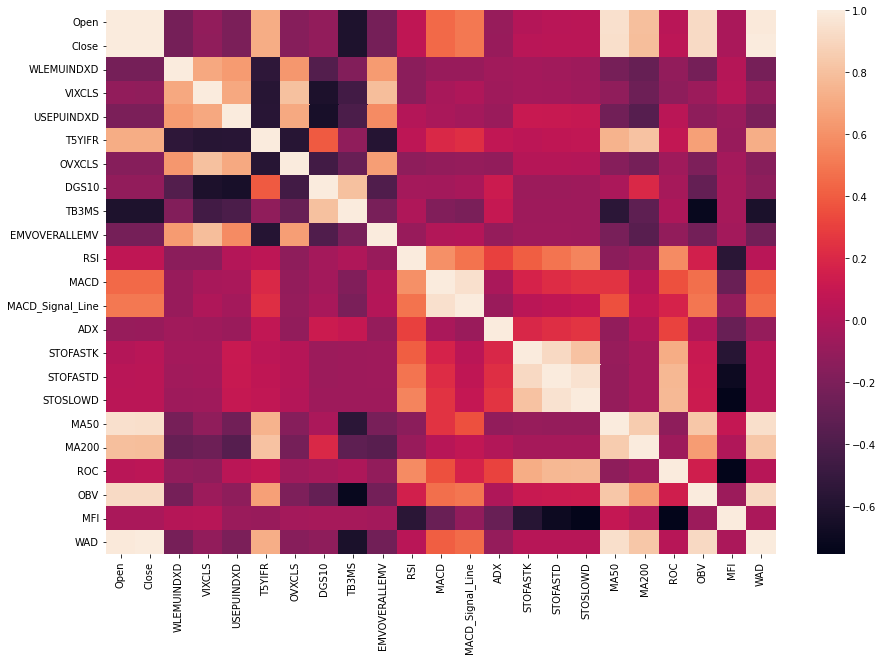

In [231]:
fig, ax = plt.subplots(figsize=(15,10))

corrMatrix = btc_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

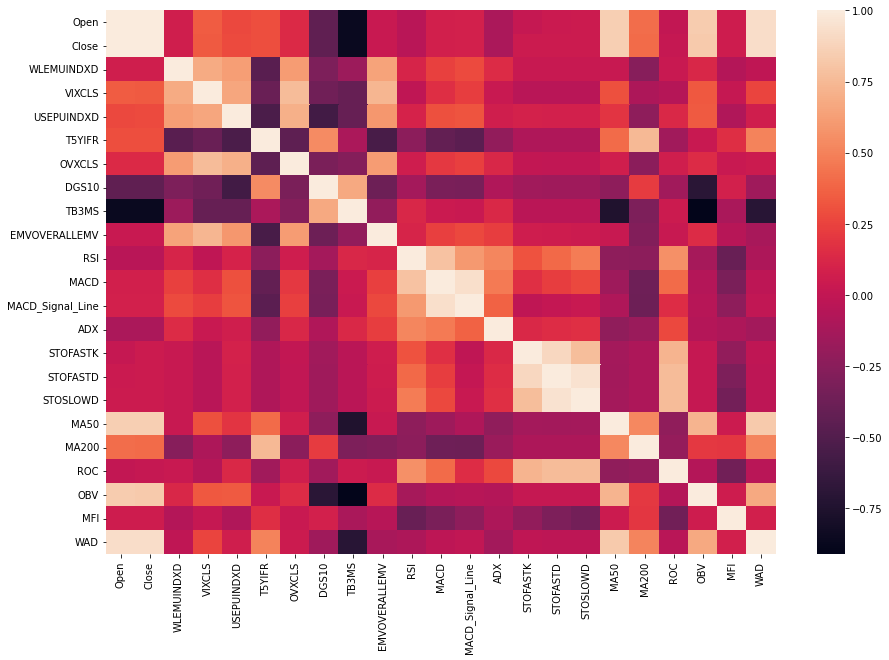

In [232]:
fig, ax = plt.subplots(figsize=(15,10))

corrMatrix = gld_df_merged.corr()
sn.heatmap(corrMatrix)
plt.show()

In [233]:
X_btc_train.info()
X_btc_train.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759 entries, 1031 to 946
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              759 non-null    float64
 1   Close             759 non-null    float64
 2   WLEMUINDXD        759 non-null    float64
 3   VIXCLS            759 non-null    float64
 4   USEPUINDXD        759 non-null    float64
 5   T5YIFR            759 non-null    float64
 6   OVXCLS            759 non-null    float64
 7   DGS10             759 non-null    float64
 8   TB3MS             759 non-null    float64
 9   EMVOVERALLEMV     759 non-null    float64
 10  RSI               759 non-null    float64
 11  MACD              759 non-null    float64
 12  MACD_Signal_Line  759 non-null    float64
 13  ADX               759 non-null    float64
 14  STOFASTK          759 non-null    float64
 15  STOFASTD          759 non-null    float64
 16  STOSLOWD          759 non-null    float64

,count,mean,std,min,25%,50%,75%,max
Open,759.0,2.207843e+04,1.922597e+04,3.401376e+03,8.253172e+03,1.057820e+04,3.750328e+04,6.754973e+04
Close,759.0,2.215028e+04,1.927858e+04,3.399472e+03,8.251856e+03,1.057553e+04,3.825038e+04,6.756683e+04
WLEMUINDXD,759.0,1.093681e+02,1.148281e+02,6.300000e+00,3.549000e+01,7.211000e+01,1.436650e+02,9.395800e+02
VIXCLS,759.0,2.145476e+01,9.276930e+00,1.154000e+01,1.566500e+01,1.880000e+01,2.455500e+01,8.269000e+01
USEPUINDXD,759.0,1.858222e+02,1.351052e+02,4.050000e+00,9.429000e+01,1.383400e+02,2.399000e+02,8.076600e+02
T5YIFR,759.0,1.899578e+00,2.570634e-01,1.100000e+00,1.740000e+00,1.900000e+00,2.110000e+00,2.410000e+00
OVXCLS,759.0,4.630767e+01,3.011166e+01,2.433000e+01,3.386000e+01,3.759000e+01,4.405000e+01,3.251500e+02
DGS10,759.0,1.462609e+00,6.004168e-01,5.200000e-01,9.150000e-01,1.520000e+00,1.775000e+00,2.790000e+00
TB3MS,759.0,7.863373e-01,9.337145e-01,2.000000e-02,5.000000e-02,1.300000e-01,1.650000e+00,2.400000e+00
EMVOVERALLEMV,759.0,2.462263e+01,9.253476e+00,1.392480e+01,1.952662e+01,2.144975e+01,2.948034e+01,6.336377e+01


In [234]:
X_gld_train.info()
X_gld_train.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 10 to 544
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              622 non-null    float64
 1   Close             622 non-null    float64
 2   WLEMUINDXD        622 non-null    float64
 3   VIXCLS            622 non-null    float64
 4   USEPUINDXD        622 non-null    float64
 5   T5YIFR            622 non-null    float64
 6   OVXCLS            622 non-null    float64
 7   DGS10             622 non-null    float64
 8   TB3MS             622 non-null    float64
 9   EMVOVERALLEMV     622 non-null    float64
 10  RSI               622 non-null    float64
 11  MACD              622 non-null    float64
 12  MACD_Signal_Line  622 non-null    float64
 13  ADX               622 non-null    float64
 14  STOFASTK          622 non-null    float64
 15  STOFASTD          622 non-null    float64
 16  STOSLOWD          622 non-null    float64
 

,count,mean,std,min,25%,50%,75%,max
Open,622.0,1687.211255,209.253481,1266.400024,1504.349976,1.773600e+03,1.839550e+03,2.053600e+03
Close,622.0,1687.463342,209.157889,1269.300049,1502.924957,1.770250e+03,1.839875e+03,2.051500e+03
WLEMUINDXD,622.0,96.684084,94.894713,6.300000,35.297500,7.061500e+01,1.216450e+02,9.395800e+02
VIXCLS,622.0,21.600691,8.006525,11.540000,16.035000,1.969000e+01,2.579500e+01,6.604000e+01
USEPUINDXD,622.0,164.049839,113.595389,19.850000,90.407500,1.285350e+02,1.966275e+02,7.380200e+02
T5YIFR,622.0,1.975868,0.266873,1.180000,1.790000,2.000000e+00,2.180000e+00,2.670000e+00
OVXCLS,622.0,45.741334,26.958063,24.000000,34.360000,3.873000e+01,4.778500e+01,3.251500e+02
DGS10,622.0,1.663215,0.704330,0.520000,1.182500,1.610000e+00,2.060000e+00,3.490000e+00
TB3MS,622.0,0.817267,0.900727,0.020000,0.050000,1.600000e-01,1.540000e+00,2.400000e+00
EMVOVERALLEMV,622.0,23.601156,8.133289,13.924800,18.806800,2.140826e+01,2.787074e+01,6.336377e+01


# ML Models


## Random Forest Classifier
Normalization is not needed for RF, refer here for more information: https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf

In [235]:
RFR_btc_model = RandomForestClassifier(n_estimators=100)
RFR_btc_model.fit(X_btc_train, Y_btc_train)

RandomForestClassifier()

In [236]:
RFR_gld_model = RandomForestClassifier(n_estimators=100)
RFR_gld_model.fit(X_gld_train, Y_gld_train)

RandomForestClassifier()

In [237]:
RFR_btc_model.predict(X_btc_test[:10])

array([ True, False,  True,  True, False, False,  True,  True,  True,
       False])

In [238]:
RFR_gld_model.predict(X_gld_test[:10])

array([False, False, False, False,  True, False, False,  True,  True,
       False])

In [239]:
Y_btc_test[:10]

Date
2021-07-23     True
2021-05-10    False
2021-02-08     True
2019-03-16    False
2019-01-10    False
2021-04-18    False
2021-07-31     True
2020-04-07    False
2021-04-02     True
2020-06-09    False
Name: Class, dtype: bool

In [240]:
Y_gld_test[:10]

Date
2021-01-04    False
2021-02-05    False
2020-04-20     True
2020-04-09    False
2020-06-23     True
2019-10-29    False
2022-05-27    False
2019-08-21     True
2020-07-27     True
2021-12-23    False
Name: Class, dtype: bool

In [241]:
RFR_btc_model.score(X_btc_test, Y_btc_test)

0.8680981595092024

In [242]:
RFR_btc_model.feature_importances_

array([0.04541349, 0.0439545 , 0.02802634, 0.0401161 , 0.03186531,
       0.0255527 , 0.05555748, 0.04671035, 0.03803928, 0.02871249,
       0.05976917, 0.05128755, 0.05416543, 0.0320095 , 0.03539612,
       0.03473887, 0.03491211, 0.08058927, 0.05744168, 0.03332602,
       0.04846853, 0.0347611 , 0.05918661])

<BarContainer object of 23 artists>

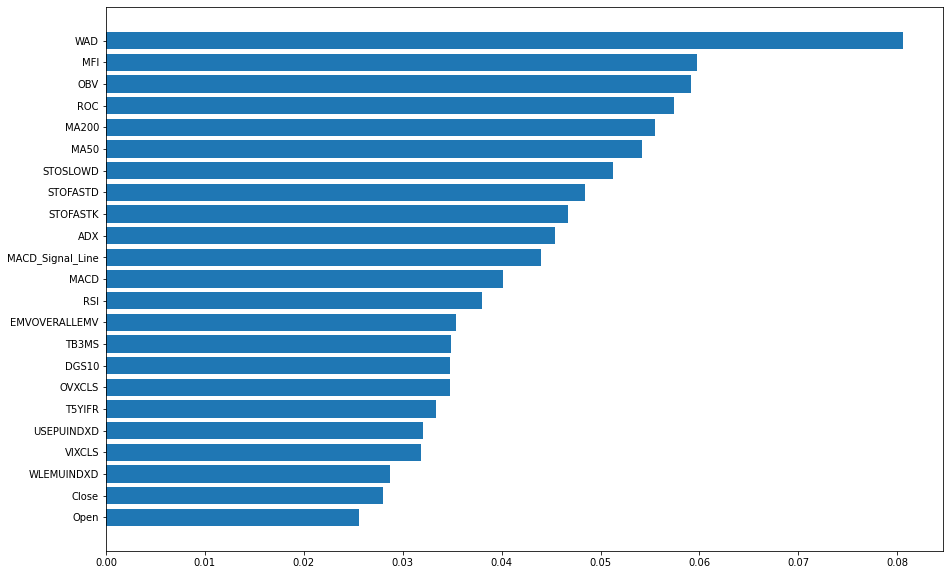

In [243]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = RFR_btc_model.feature_importances_.argsort()
plt.barh(X_btc_test.columns, RFR_btc_model.feature_importances_[sorted_idx])

In [244]:
perm_importance = permutation_importance(RFR_btc_model, X_btc_test, Y_btc_test)

Text(0.5, 0, 'Permutation Importance')

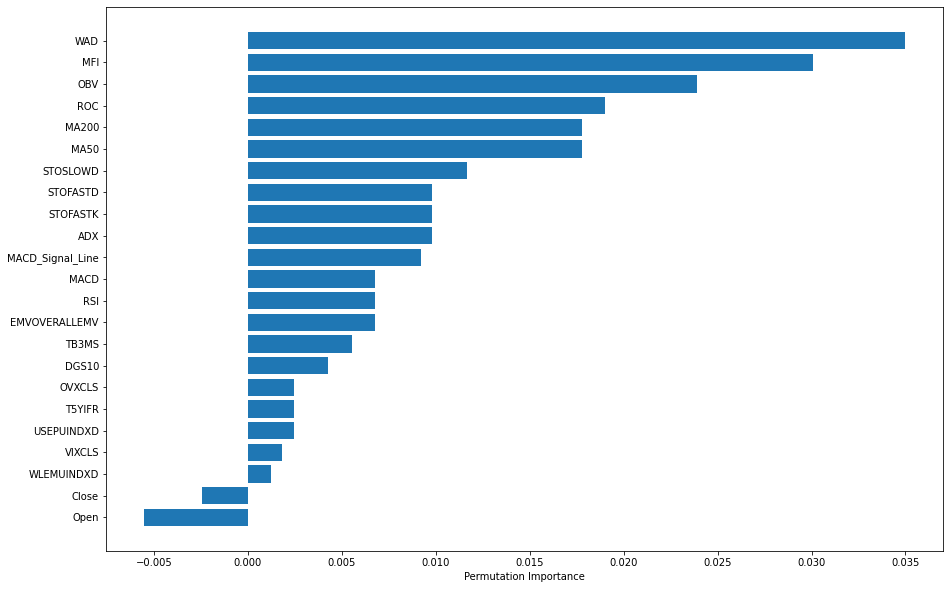

In [245]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_btc_test.columns, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [246]:
explainer = shap.TreeExplainer(RFR_btc_model)
shap_values = explainer.shap_values(X_btc_test)

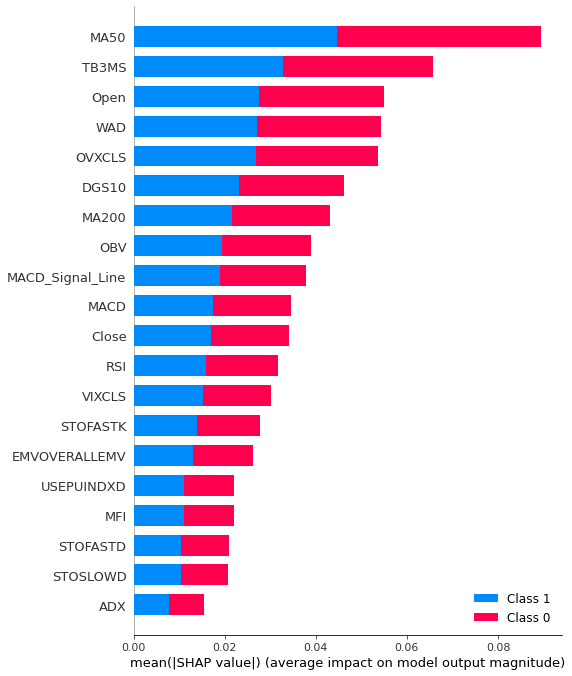

In [247]:
shap.summary_plot(shap_values, X_btc_test, plot_type="bar")

In [248]:
RFR_gld_model.score(X_gld_test, Y_gld_test)

0.8277153558052435

In [249]:
RFR_gld_model.feature_importances_

array([0.06681802, 0.05788364, 0.02287379, 0.03223235, 0.02699571,
       0.03722215, 0.03634035, 0.0552147 , 0.02409812, 0.04208469,
       0.05095621, 0.04401732, 0.03798385, 0.04848121, 0.02856867,
       0.02821744, 0.02844444, 0.06514955, 0.04589303, 0.04697033,
       0.06452697, 0.04800873, 0.06101871])

<BarContainer object of 23 artists>

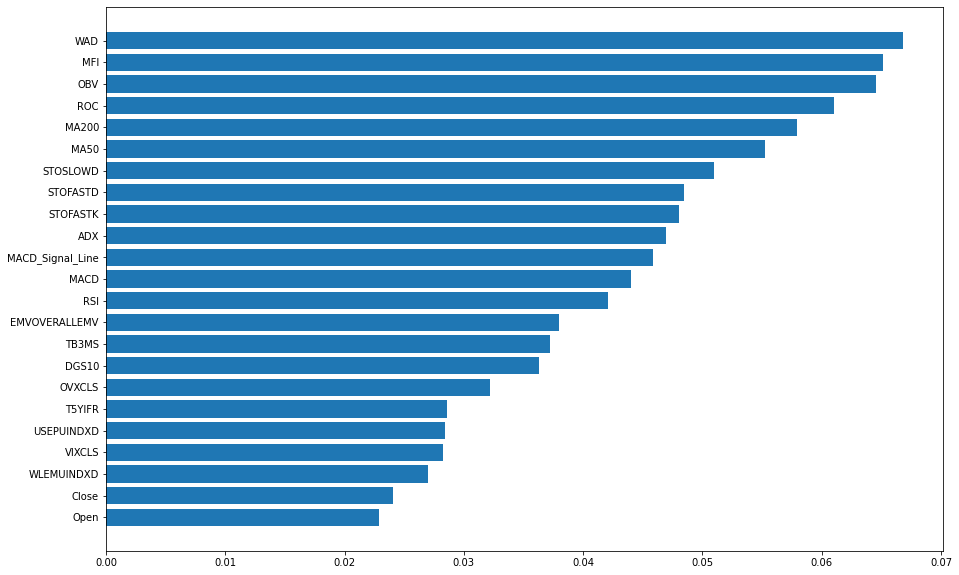

In [250]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = RFR_gld_model.feature_importances_.argsort()
plt.barh(X_gld_test.columns, RFR_gld_model.feature_importances_[sorted_idx])

In [251]:
perm_importance = permutation_importance(RFR_gld_model, X_gld_test, Y_gld_test)

Text(0.5, 0, 'Permutation Importance')

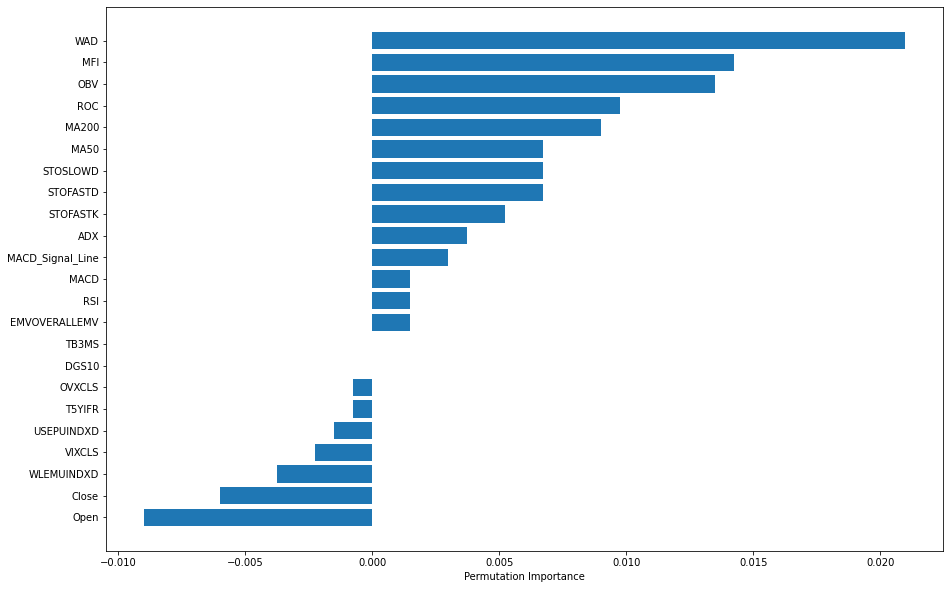

In [252]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_gld_test.columns, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [253]:
explainer = shap.TreeExplainer(RFR_gld_model)
shap_values = explainer.shap_values(X_gld_test)

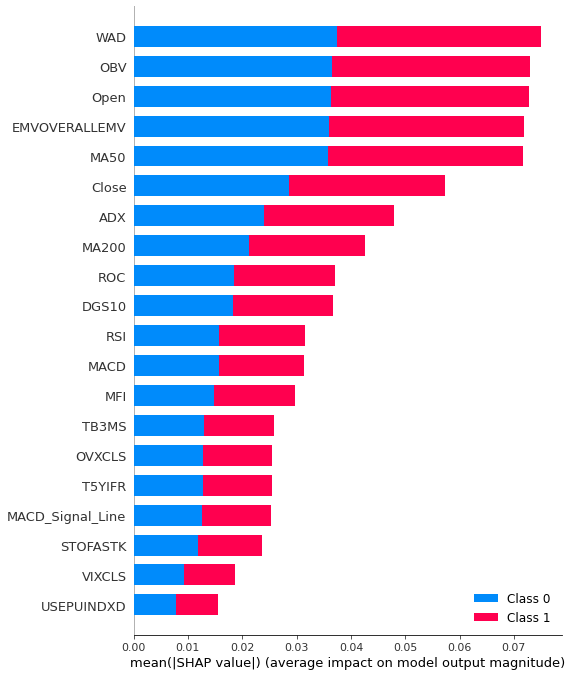

In [254]:
shap.summary_plot(shap_values, X_gld_test, plot_type="bar")

# Gradient Boosting Classifier

In [255]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)

In [256]:
gradient_booster.fit(X_btc_train, Y_btc_train)

GradientBoostingClassifier()

In [257]:
print(classification_report(Y_btc_test,gradient_booster.predict(X_btc_test)))

              precision    recall  f1-score   support

       False       0.84      0.79      0.81       137
        True       0.85      0.89      0.87       189

    accuracy                           0.85       326
   macro avg       0.85      0.84      0.84       326
weighted avg       0.85      0.85      0.85       326



## Bagging Classifier

In [258]:
model = BaggingClassifier()
# evaluate the model
model.fit(X_btc_train, Y_btc_train)

BaggingClassifier()

In [259]:
y_pred = model.predict(X_btc_test)

In [260]:
print("Classification Report \n", classification_report(Y_btc_test,y_pred))

Classification Report 
               precision    recall  f1-score   support

       False       0.83      0.88      0.85       137
        True       0.91      0.87      0.89       189

    accuracy                           0.87       326
   macro avg       0.87      0.87      0.87       326
weighted avg       0.87      0.87      0.87       326



In [261]:
cm = confusion_matrix(Y_btc_test,y_pred) 
print("Confusion Matrix \n", cm)
print("Accuracy Score",accuracy_score(Y_btc_test, y_pred))

Confusion Matrix 
 [[120  17]
 [ 25 164]]
Accuracy Score 0.8711656441717791


## Logisitic Regression


In [262]:
scaler = MinMaxScaler()
X_btc_train_norm = scaler.fit_transform(X_btc_train)
X_btc_test_norm = scaler.fit_transform(X_btc_test)

In [263]:
LR_btc_model = LogisticRegression()
LR_btc_model.fit(X_btc_train_norm, Y_btc_train)

LogisticRegression()

In [264]:
Y_btc_predict = LR_btc_model.predict(X_btc_test_norm)
print("Accuracy Score is {}".format(accuracy_score(Y_btc_test, Y_btc_predict)))

Accuracy Score is 0.6533742331288344


In [265]:
scaler = MinMaxScaler()
X_gld_train_norm = scaler.fit_transform(X_gld_train)
X_gld_test_norm = scaler.fit_transform(X_gld_test)

In [266]:
LR_gld_model = LogisticRegression()
LR_gld_model.fit(X_gld_train_norm, Y_gld_train)

LogisticRegression()

In [267]:
Y_gld_predict = LR_gld_model.predict(X_gld_test_norm)
print("Accuracy Score is {}".format(accuracy_score(Y_gld_test, Y_gld_predict)))

Accuracy Score is 0.6292134831460674
